### Targeted lipidomics analysis of Pancreas Tissue using LC-MS (Xcalibur) 
#### Comparison is healthy donors, type 1 diabetes donors and type 2 diabetes donors 
###### Details regarding sample groups can be found in README

In [2]:
### Import necessary libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import scipy as sp

import sklearn as sk

from sklearn.decomposition import PCA
from scipy.stats import zscore

In [ ]:
### Loading lipidomics dataset into pandas df

# Load dataset
lipidomicsDF = pd.read_csv('lipidomicsdatafinal.csv')

# Create a deep copy for analysis
lipidomicsRawAnalysisDf = lipidomicsDF.copy()

# Quick inspection of data types and nulls
lipidomicsRawAnalysisDf.head()

# Make SampleID the index
lipidomicsRawAnalysisDf.set_index('Samples', inplace=True)

# print(lipidomicsRawAnalysisDf.head)
# Statistical summary
# lipidomicsRawAnalysisDf.describe()

<bound method NDFrame.head of                  Group  CAR 02:0*  CAR 03:0*  CAR 05:0*  CAR 08:0*  \
Samples                                                              
651_CR            T2DM   0.048330   0.002429   0.000724   0.000000   
668_C             T2DM   0.057002   0.000990   0.000313   0.000000   
671_C             T2DM   0.146065   0.003168   0.001261   0.000000   
674_CR            T2DM   0.067519   0.002190   0.000479   0.000000   
677_B        T1DM_T2DM   0.060186   0.001286   0.000444   0.000000   
679_CR       T1DM_T2DM   0.105556   0.003534   0.000810   0.000000   
682_B             T2DM   0.073154   0.000919   0.000319   0.000000   
685_BR            T1DM   0.074858   0.001686   0.000482   0.000000   
687_B          HEALTHY   0.048516   0.000455   0.000239   0.000000   
690_B             T2DM   0.094610   0.001307   0.000488   0.000000   
692_BR         HEALTHY   0.109054   0.003197   0.000735   0.000000   
699_CR            T2DM   0.039728   0.000849   0.000258   0.

In [ ]:
# How many zero values are in each column/lipid species

# Count zeros for each column (lipids)
zeroCountsLipids = (lipidomicsRawAnalysisDf == 0.0).sum()

# Count zeros for each row (donors/samples)
zeroCountsDonors = (lipidomicsRawAnalysisDf == 0.0).sum(axis=1)

# Create DataFrame with donor names, zero counts, and percentage
totalLipids = lipidomicsRawAnalysisDf.shape[1]  # Total number of columns (lipids)

zeroCountsDonorsDf = pd.DataFrame({
    'Samples': lipidomicsRawAnalysisDf.index,
    'ZeroCount': zeroCountsDonors.values,
    'ZeroPercentage': (zeroCountsDonors.values / totalLipids) * 100
})

# Similarly for lipids
totalDonors = lipidomicsRawAnalysisDf.shape[0]  # Total number of rows (donors)

zeroCountsLipidsDf = pd.DataFrame({
    'Lipid': zeroCountsLipids.index,
    'ZeroCount': zeroCountsLipids.values,
    'ZeroPercentage': (zeroCountsLipids.values / totalDonors) * 100
})

# Display first 40 entries of each
# zeroCountsLipidsDf.head(40)
zeroCountsDonorsDf.head(40)


,Samples,ZeroCount,ZeroPercentage
0,651_CR,31,10.689655
1,668_C,29,10.000000
2,671_C,26,8.965517
3,674_CR,26,8.965517
4,677_B,25,8.620690
5,679_CR,34,11.724138
6,682_B,27,9.310345
7,685_BR,32,11.034483
8,687_B,29,10.000000
9,690_B,23,7.931034


In [ ]:
# Here we are looking for number of "Technical Nulls" (NaNs), not "Numerical Nulls" (Zeros).

# This scans every single cell in your DataFrame. If a cell contains a missing value (like NaN or None), it marks it as True. 
# If it contains a number (even 0), it marks it as False. 
# The first .sum() counts the number of True values in each individual column. 
# The second .sum() adds all those column totals together to give you one single integer representing every missing data point in the entire table

lipid_IsNull_Missing = lipidomicsRawAnalysisDf.isnull().sum().sum()
if lipid_IsNull_Missing == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"Total missing values: {lipid_IsNull_Missing}")

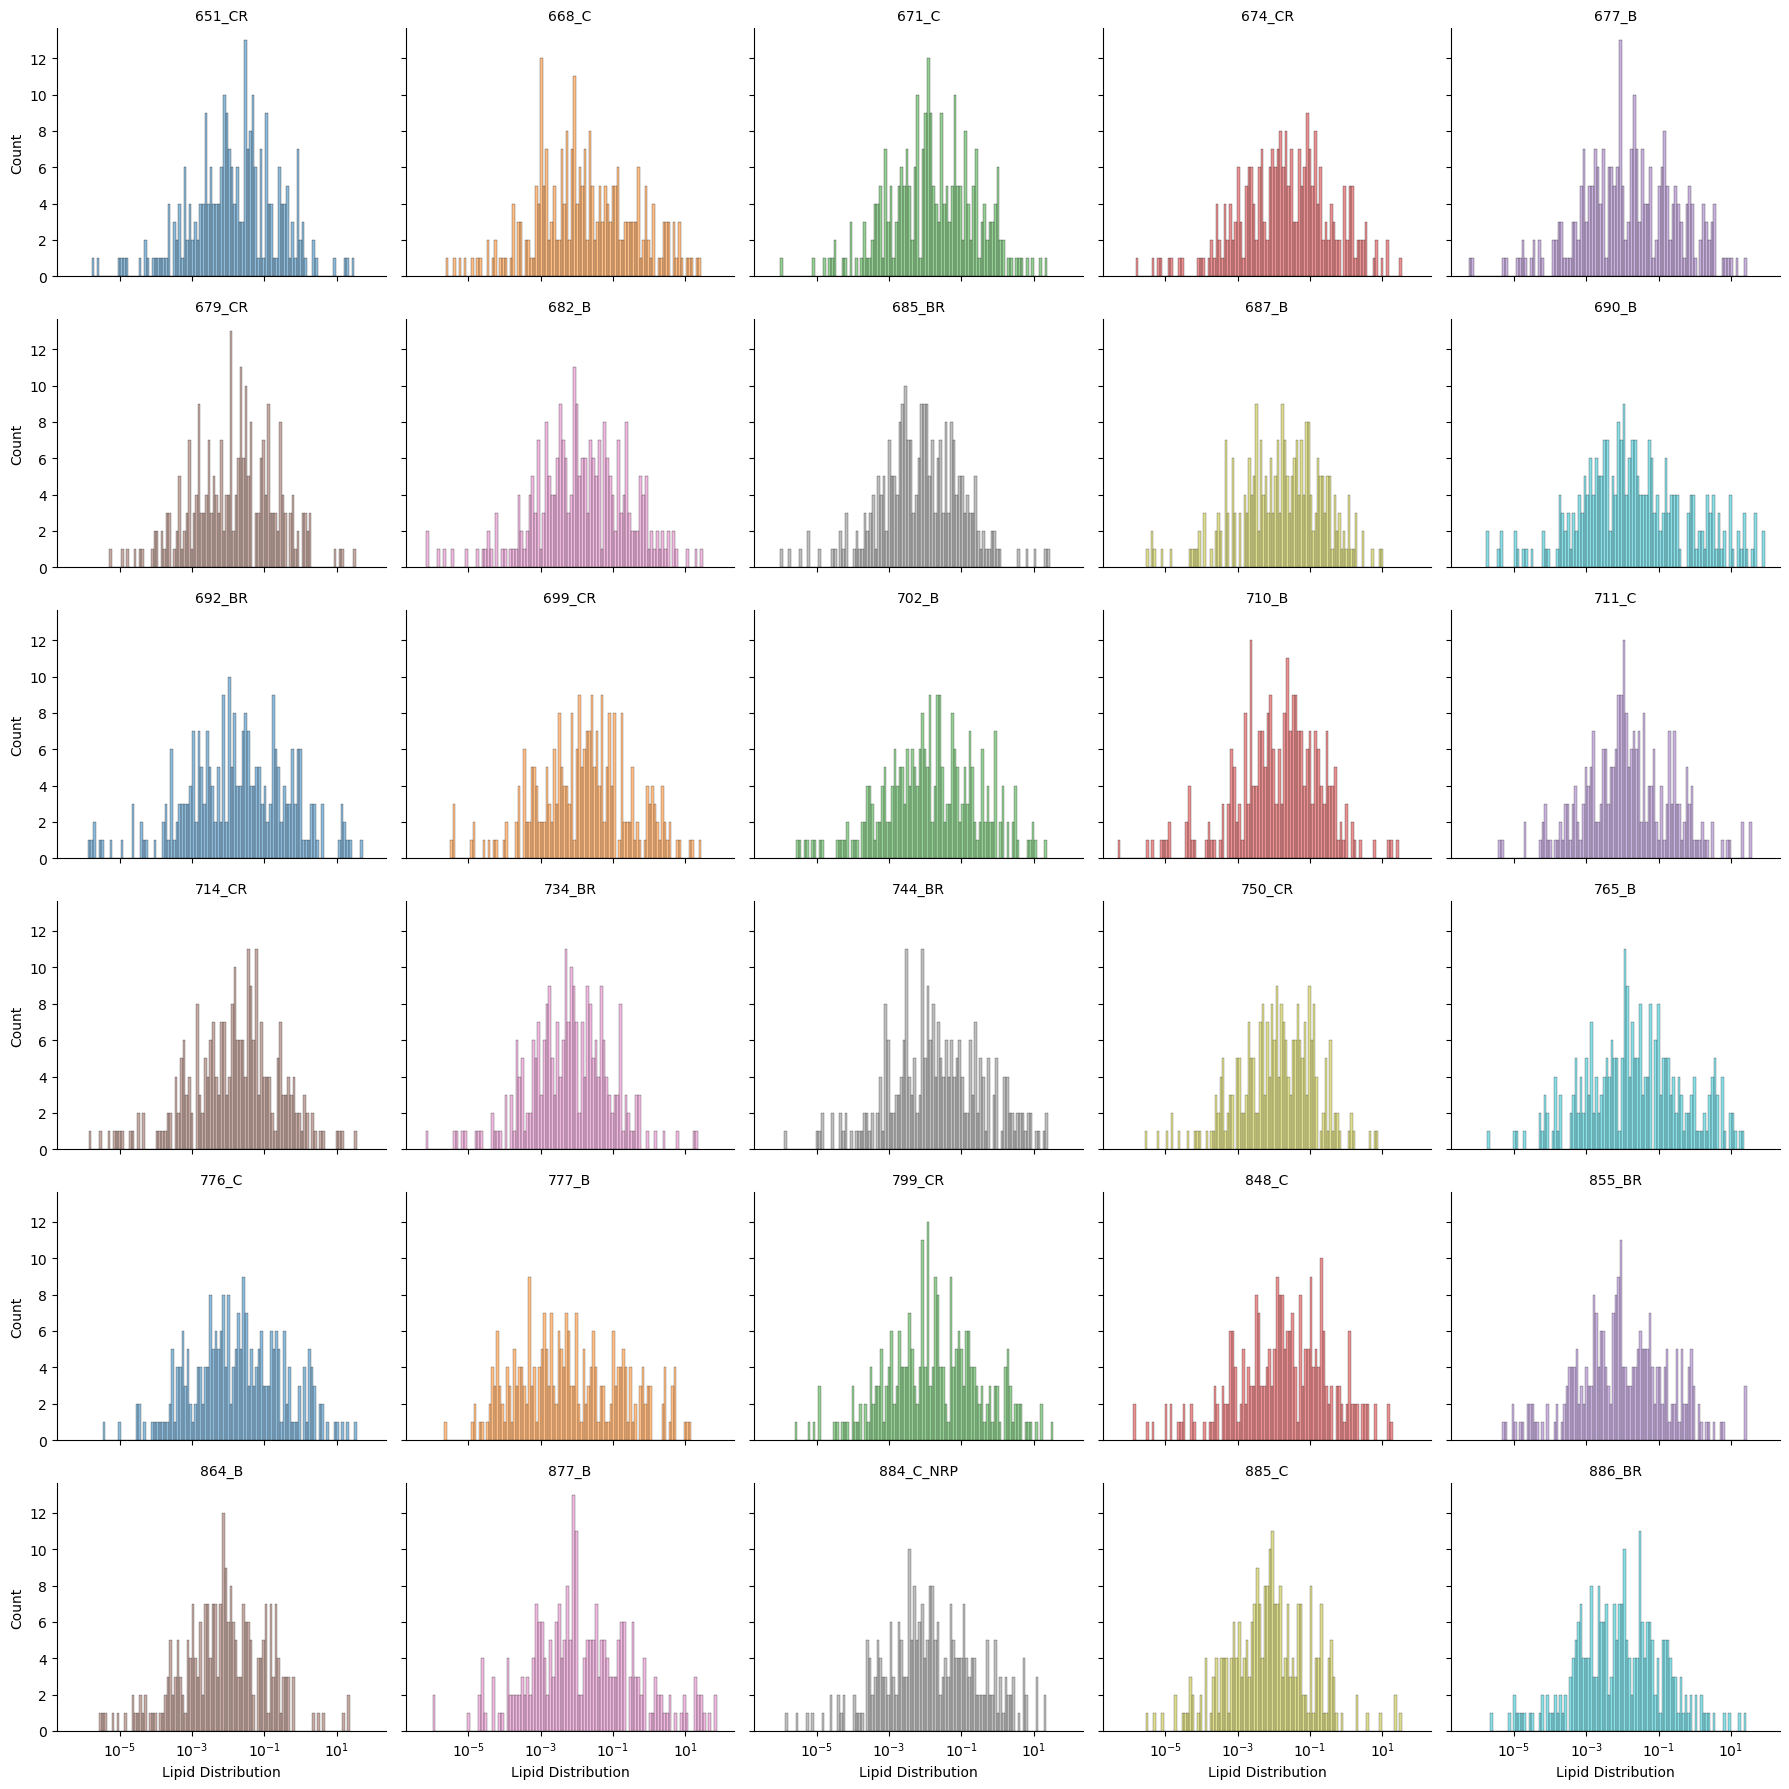

<Figure size 1400x600 with 0 Axes>

In [ ]:
# Creating a simple histogram of lipid counts for each donor

# Melt the DataFrame to long format (excluding the 'Group' column)

# Get list of columns excluding 'Group'
df_Cols_Names = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group'] 

# Starts transforming the DataFrame from wide format to long format using pandas' melt() function.

# Reset index to convert 'Samples' from index to column
lipidomicsLongRawDf = lipidomicsRawAnalysisDf.reset_index().melt(
    id_vars = ['Samples', 'Group'],
    value_vars = df_Cols_Names,
    var_name = 'Lipid',
    value_name = 'Distribution'
)

# Begin plotting using seaborn's FacetGrid to create histograms for each donor/sample.
facet_Grid_Plot = sns.FacetGrid(
    lipidomicsLongRawDf, 
    col='Samples',
    col_wrap=5, 
    hue='Samples', 
    aspect=1.2, 
    height=3, 
    palette='tab10'
)

facet_Grid_Plot.map(
    sns.histplot, 
    'Distribution', 
    bins=100, 
    kde=True,
    log_scale=True 
)

facet_Grid_Plot.set_titles(col_template="{col_name}")
facet_Grid_Plot.set_xlabels('Lipid Distribution')

plt.figure(figsize=(14, 6))
plt.tight_layout()
plt.show()
plt.close()